# --------------------------------- Decision Tree ------------------------------------

# 1. Data Preparation and Setup

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

# Set visualization style for better plots
sns.set_style("whitegrid")

In [34]:
df = pd.read_excel("heart_disease.xlsx",sheet_name=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [35]:
print("--- Initial DataFrame Head ---")
print(df.head())

print("\n--- DataFrame Information ---")
print(df.info())

--- Initial DataFrame Head ---
   age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0  

--- DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
-

# 2. Exploratory Data Analysis (EDA) & Data Cleaning

### A. Missing Values and Inconsistencies

In [36]:
# Check for missing values, including those represented by '?'
df = df.replace('?', np.nan)
print("\n--- Missing Values Count (after replacing '?' with NaN) ---")
print(df.isnull().sum())

# 'oldpeak' is the only column with missing values (62 NaNs).
# Since it is a numerical feature, we impute the missing values with the median.
oldpeak_median = df['oldpeak'].median()
df['oldpeak'].fillna(oldpeak_median, inplace=True)

print("\n--- Final Missing Values Check ---")
print(df.isnull().sum())

# Correcting a data typo in 'exang' (Exercise Induced Angina)
# The unique values showed 'TURE' which is corrected to 'True'.
df['exang'].replace('TURE', 'True', inplace=True)
print("\n--- Unique values in 'exang' after correction ---")
print(df['exang'].unique())


--- Missing Values Count (after replacing '?' with NaN) ---
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

--- Final Missing Values Check ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

--- Unique values in 'exang' after correction ---
[False True 'FALSE' 'True']


### B. Target Variable Transformation

In [37]:
# Create a binary target variable
# 0 = No Disease, 1 = Disease (stages 1, 2, 3, 4)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

print("\n--- Target Variable 'target' Distribution ---")
print(df['target'].value_counts(normalize=True))

# Visualize the target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable (0: No Disease, 1: Disease)')
plt.xlabel('Heart Disease Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.savefig('target_distribution.png')
plt.close()


--- Target Variable 'target' Distribution ---
target
1    0.560573
0    0.439427
Name: proportion, dtype: float64


# 3. Feature Engineering

In [38]:
# Identify categorical columns based on the DataFrame info:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Perform One-Hot Encoding and drop the first category to prevent multicollinearity
# Also drop the original multi-class 'num' column
df_final = pd.get_dummies(df.drop(columns=['num']), columns=categorical_cols, drop_first=True)

print("\n--- Final Encoded DataFrame Head ---")
print(df_final.head())

# Define features (X) and target (y)
X = df_final.drop('target', axis=1)
y = df_final['target']


--- Final Encoded DataFrame Head ---
   age  trestbps  chol  thalch  oldpeak  target  sex_Male  cp_atypical angina  \
0   63       145   233     150      2.3       0      True               False   
1   41       135   203     132      0.0       0      True                True   
2   57       140   192     148      0.4       0      True               False   
3   52       118   186     190      0.0       0      True               False   
4   57       110   201     126      1.5       0      True               False   

   cp_non-anginal  cp_typical angina  fbs_True  restecg_normal  \
0           False               True      True           False   
1           False              False     False            True   
2           False              False     False            True   
3           False               True     False           False   
4           False              False     False            True   

   restecg_st-t abnormality  exang_True  exang_FALSE  exang_True  slope_flat  

# 4. Decision Tree Classification

## A. Data Split

In [39]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 726 samples
Testing set size: 182 samples


## B. Default Model Implementation and Evaluation

In [40]:
# Initialize and train the default Decision Tree Classifier
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_default = dt_default.predict(X_test)
y_proba_default = dt_default.predict_proba(X_test)[:, 1]

accuracy_default = accuracy_score(y_test, y_pred_default)
roc_auc_default = roc_auc_score(y_test, y_proba_default)

print("\n--- Default Decision Tree Model Performance ---")
print(f"Accuracy: {accuracy_default:.4f}")
print(f"ROC-AUC: {roc_auc_default:.4f}")


--- Default Decision Tree Model Performance ---
Accuracy: 0.6978
ROC-AUC: 0.6980


# 5. Hyperparameter Tuning

In [41]:
# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None], # Max depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV (using n_jobs=1 to prevent potential environment-specific errors)
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=1 # Sequential processing
)

# Perform the grid search
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\n--- Hyperparameter Tuning Results ---")
print(f"Best Parameters: {best_params}")


--- Hyperparameter Tuning Results ---
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


# 6. Model Evaluation and Analysis

## A. Tuned Model Evaluation

In [42]:
# Evaluate the tuned model
y_pred_tuned = best_dt.predict(X_test)
y_proba_tuned = best_dt.predict_proba(X_test)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)

print("\n--- Tuned Decision Tree Model Performance ---")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")


--- Tuned Decision Tree Model Performance ---
Accuracy: 0.7143
Precision: 0.8125
Recall: 0.6373
F1-Score: 0.7143
ROC-AUC: 0.7721


## B. Visualization 

### 1. Target Variable Distribution

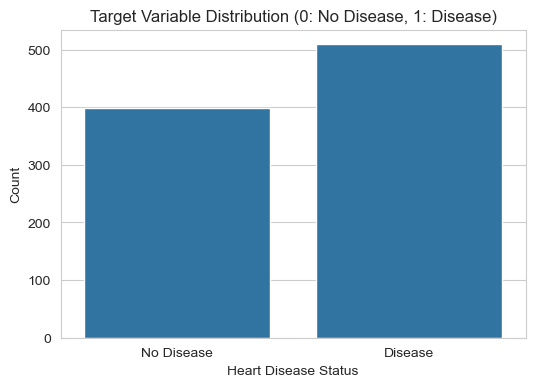

In [43]:
# A. Target Distribution (Bar Chart)
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution (0: No Disease, 1: Disease)')
plt.xlabel('Heart Disease Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.savefig('eda_target_distribution.png')
plt.show()

### 2. Numerical Feature Distributions (Histograms)

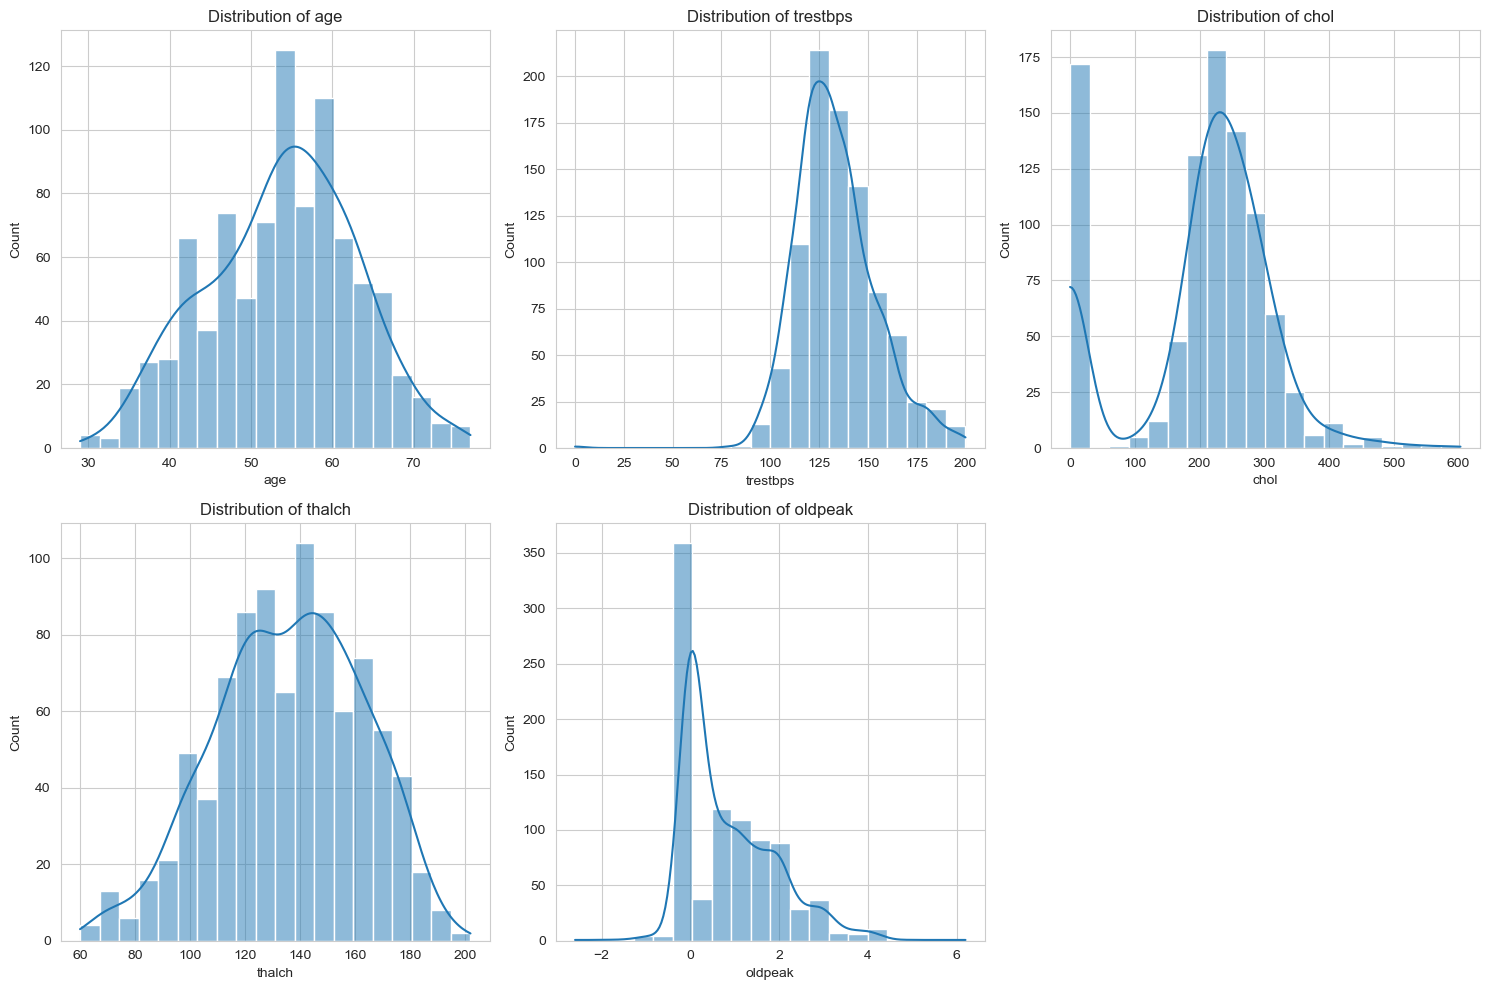

In [44]:
# B. Numerical Feature Distributions (Histograms)
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.savefig('eda_numerical_distributions.png')
plt.show()

### 3. Correlation with Target Variable (Heatmap)

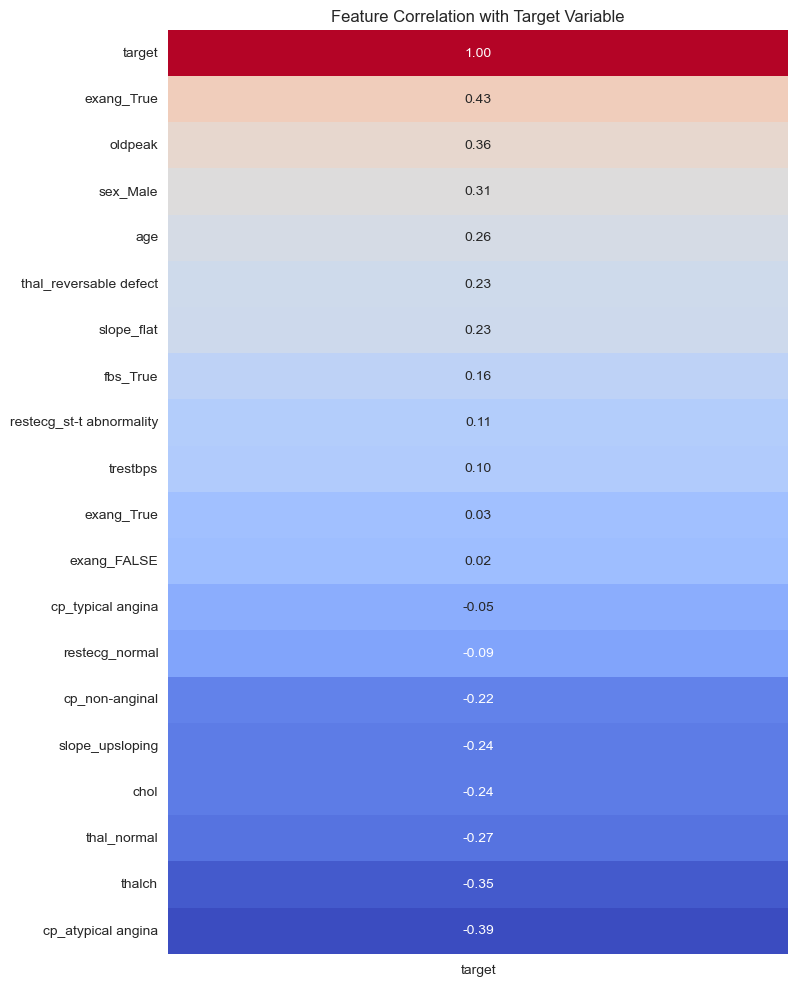

In [45]:
# C. Correlation Matrix (Heatmap)
# Uses the One-Hot Encoded DataFrame (df_final)
correlation_matrix = df_final.corr()
target_corr = correlation_matrix['target'].sort_values(ascending=False).to_frame()

plt.figure(figsize=(8, 12))
sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Feature Correlation with Target Variable')
plt.yticks(rotation=0)
plt.savefig('eda_target_correlation_heatmap.png')
plt.show()

### 4. Confusion Matrix

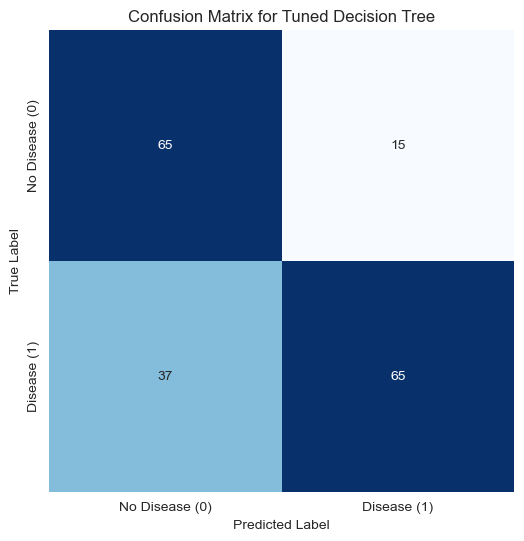

In [46]:
# Confusion Matrix (Tuned Model)
y_pred_tuned = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease (0)', 'Disease (1)'],
            yticklabels=['No Disease (0)', 'Disease (1)'])
plt.title('Confusion Matrix for Tuned Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('tuned_dt_confusion_matrix.png')
plt.show()

### 5. ROC Curve

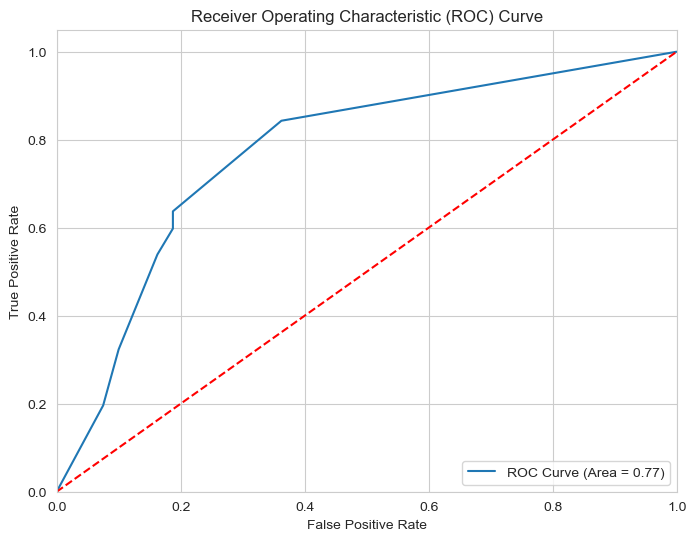

In [47]:
# ROC Curve (Tuned Model)
y_proba_tuned = best_dt.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_tuned)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('tuned_dt_roc_curve.png')
plt.show()

### 6.Decision Tree Structure

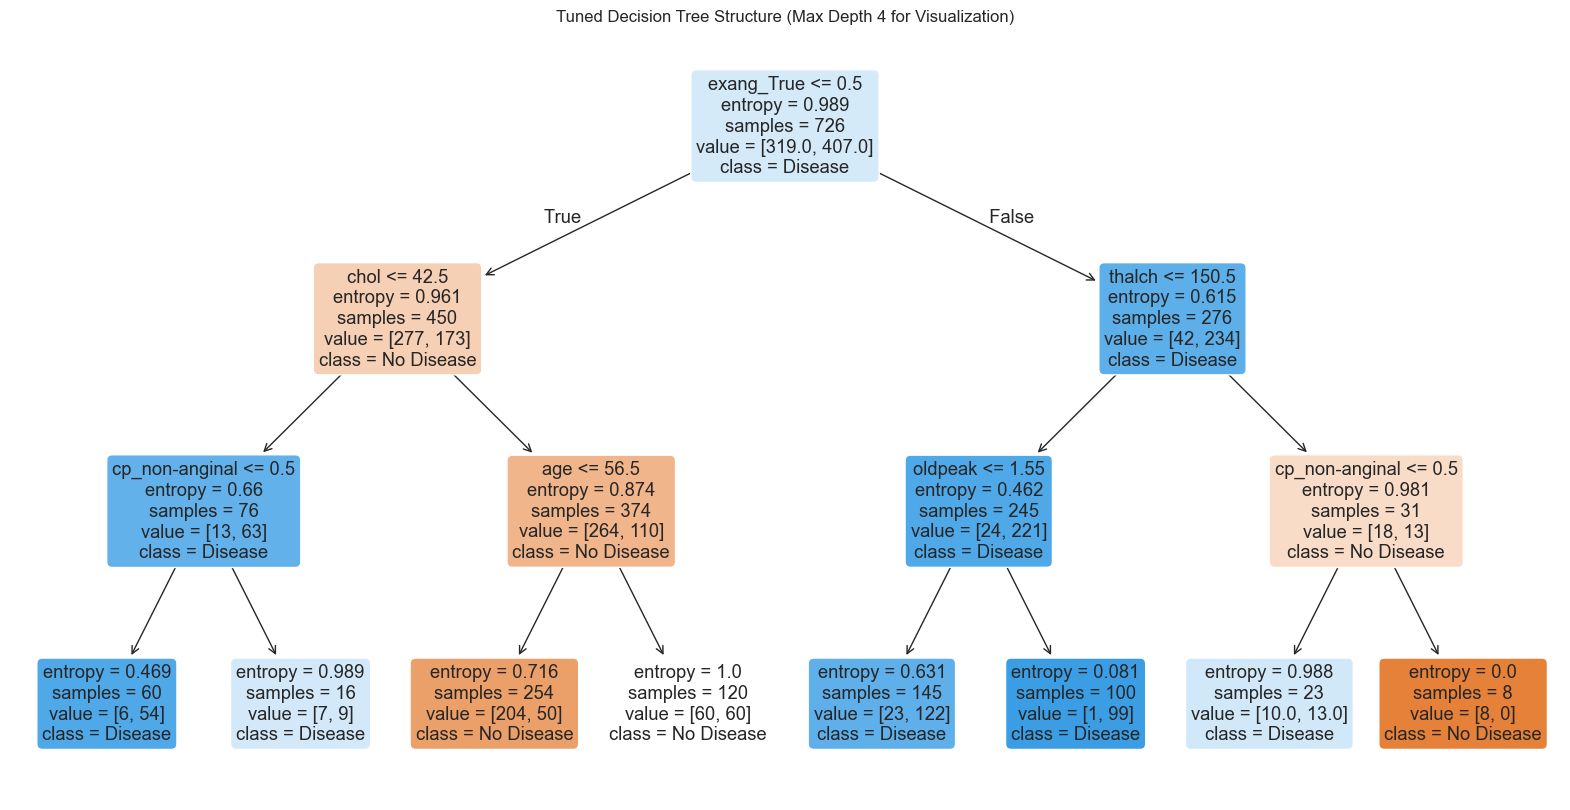

In [48]:
# Decision Tree Structure (Best Tree)
plt.figure(figsize=(20, 10))
plot_tree(best_dt,
          feature_names=X.columns.tolist(),
          class_names=['No Disease', 'Disease'],
          filled=True,
          rounded=True,
          max_depth=4) # Limiting depth for clear visualization
plt.title('Tuned Decision Tree Structure (Max Depth 4 for Visualization)')
plt.savefig('tuned_decision_tree_structure.png')
plt.show()

### 7.Feature Importance

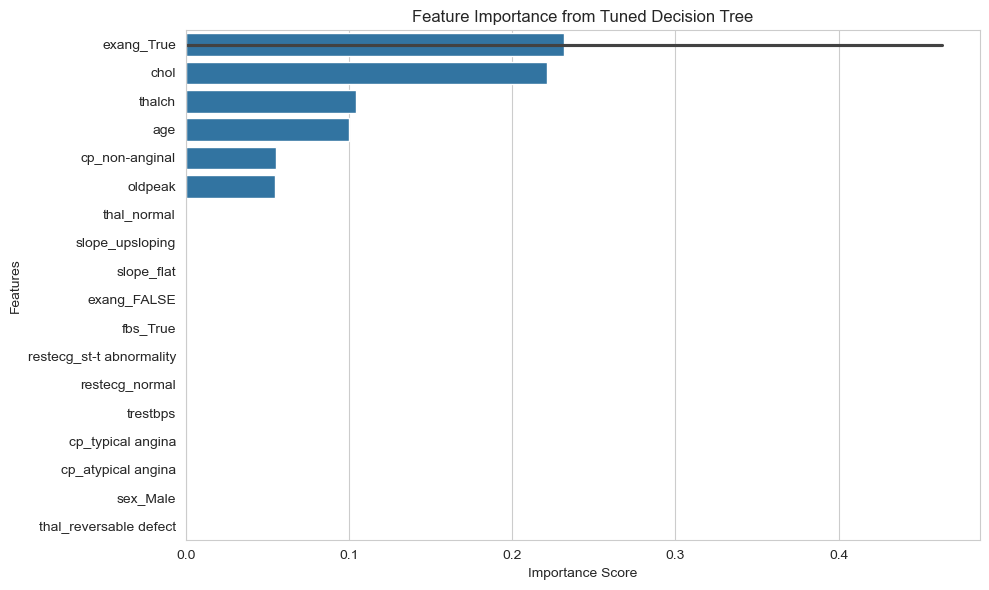

In [49]:
#Feature Importance
feature_importance = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance from Tuned Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('tuned_dt_feature_importance.png')
plt.show()

# Interview Question

## 1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?
Decision Tree models rely on several key hyperparameters to control complexity and prevent overfitting. The most common hyperparameters include max_depth, which sets the maximum number of levels in the tree; limiting this value forces the model to generalize and stops it from becoming too specific to the training data. min_samples_split dictates the minimum number of samples an internal node must have to be considered for splitting; setting a higher value makes the model more cautious about splitting, reducing complexity. Similarly, min_samples_leaf specifies the minimum number of samples required to be at any leaf node, directly affecting how granular the final decision rules are. Finally, the criterion (typically Gini impurity or entropy/information gain) determines the mathematical function used to measure the quality of a split; while both usually yield similar results, they slightly affect which features are prioritized. Generally, tuning these parameters involves finding the sweet spot between an overly complex, overfit model and a too-simple, underfit model to maximize predictive performance on unseen data.

## 2. What is the difference between the Label encoding and One-hot encoding?
The fundamental difference between Label Encoding and One-Hot Encoding lies in how they handle categorical data for machine learning models. Label Encoding assigns a unique integer to each category (e.g., Red: 1, Green: 2, Blue: 3). This method is appropriate only for ordinal data (categories with a natural order, like Low, Medium, High) because it mistakenly introduces an artificial numerical relationship or rank to nominal data; a model might incorrectly assume that category '3' is "greater" than category '1'. In contrast, One-Hot Encoding creates a new binary column (a "dummy variable") for each unique category, marking a '1' in the column that corresponds to the sample's category and '0's elsewhere (e.g., Red becomes [1, 0, 0]). This eliminates the false numerical ordering, making it the preferred and necessary technique for nominal data (categories without an intrinsic order, like City or Chest Pain Type), even though it increases the dimensionality (number of features) of the dataset.